<a href="https://colab.research.google.com/github/Kaustuv1234/ML-Practice/blob/main/LogReg_pytorch_W%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install wandb

In [29]:
import wandb
!wandb login

wandb: Currently logged in as: unbiasedhuman. Use `wandb login --relogin` to force relogin


In [30]:
import torch
from torchvision import transforms, datasets
import time
import random

In [31]:
image_transforms = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=image_transforms
)

test_data = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=image_transforms
)

print(f'train size:{len(train_data)}')
print(f'test size:{len(test_data)}')

train size:60000
test size:10000


In [32]:
config = {"batch_size" : 128,
          "lr" : 0.03,
          "epochs" : 10}

In [33]:
VALIDATION_RATIO = 0.9

train_valid_ratio = [int(len(train_data)*VALIDATION_RATIO), len(train_data)-int(len(train_data)*VALIDATION_RATIO)]
train_valid_ratio

train_data, valid_data = torch.utils.data.random_split(train_data, train_valid_ratio)

In [34]:
BATCH_SIZE = config["batch_size"]

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

print('No of batches:')
print(f'\ttraining: {len(train_loader)}')
print(f'\ttest: {len(test_loader)}')
print(f'\tvalid: {len(valid_loader)}')

No of batches:
	training: 422
	test: 79
	valid: 47


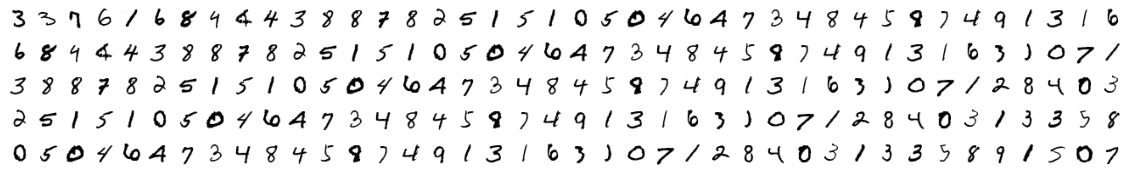

In [35]:
import matplotlib.pyplot as plt

for i in train_loader:
  break
  
r, c = 5, 40
f, axarr = plt.subplots(r, c)
plt.rcParams["figure.figsize"] = (20,3)

for ii in range(r):
  for jj in range(c):
    axarr[ii, jj].imshow(i[0][r*ii+jj].numpy().squeeze(), cmap='gray_r')
    axarr[ii, jj].axis('off')


In [36]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LogReg(nn.Module):
  def __init__(self, input_dim=28*28, output_dim=10):
    super(LogReg, self).__init__()
    self.lin = nn.Linear(input_dim, output_dim)

  def forward(self, x):
    x = x.view(-1, 784)
    output = self.lin(x)
    return output

In [37]:
def get_accuracy(output, label):
  pred = output.argmax(1, keepdim=False)
  correct = pred.eq(label.view_as(pred)).sum()
  acc = correct.float() / label.shape[0]
  return acc

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [39]:
def train(model, error, optimizer, train_loader):
  train_loss = 0
  train_acc = 0
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    output = model(image)

    loss = error(output, label)
    acc = get_accuracy(output, label)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_acc += acc.item()
  
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  return train_loss, train_acc

In [40]:
def validate(model, error, test_loader): 
  loss_valid = 0
  acc_valid = 0       
  model.eval()  

  for step in range(len(test_loader)):
    images , labels = next(iter(test_loader))
    
    images = images.to(device)
    labels = labels.to(device)
    
    output = model(images)
    
    loss_valid_step = error(output , labels)
    acc_valid_step = get_accuracy(output, labels)
  
    loss_valid += loss_valid_step.item()
    acc_valid += acc_valid_step.item()

  loss_valid /= len(test_loader)
  acc_valid /= len(test_loader)

  return loss_valid, acc_valid

In [41]:
wandb.init(name = 'LOG_REG',
           project='MNIST',
           config=config,
           notes=f'simply testing the wandb package (device:{device})',
           tags=['MNIST', 'LOG_REG', 'Introduction'])

error = nn.CrossEntropyLoss()
model = LogReg().to(device)
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

wandb.watch(model)

EPOCHS = config['epochs']
start_time = time.time()

for epoch in range(1, EPOCHS+1):
  loss_train, acc_train = train(model, error, optimizer, train_loader)
  loss_valid, acc_valid = validate(model, error, valid_loader)

  print(f'\tTrain Loss: {loss_train:.3f} | Train Acc: {acc_train*100:.2f}%')
  print(f'\t Val. Loss: {loss_valid:.3f} |  Val. Acc: {acc_valid*100:.2f}%')

  wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid})
print("Time Elapsed : {:.4f}s".format(time.time() - start_time))

	Train Loss: 0.401 | Train Acc: 88.96%
	 Val. Loss: 0.384 |  Val. Acc: 90.31%
	Train Loss: 0.364 | Train Acc: 90.77%
	 Val. Loss: 0.426 |  Val. Acc: 89.66%
	Train Loss: 0.364 | Train Acc: 90.72%
	 Val. Loss: 0.459 |  Val. Acc: 89.44%
	Train Loss: 0.362 | Train Acc: 90.94%
	 Val. Loss: 0.433 |  Val. Acc: 90.44%
	Train Loss: 0.357 | Train Acc: 91.12%
	 Val. Loss: 0.438 |  Val. Acc: 90.21%
	Train Loss: 0.360 | Train Acc: 91.07%
	 Val. Loss: 0.412 |  Val. Acc: 90.89%
	Train Loss: 0.357 | Train Acc: 91.16%
	 Val. Loss: 0.474 |  Val. Acc: 89.36%
	Train Loss: 0.346 | Train Acc: 91.40%
	 Val. Loss: 0.484 |  Val. Acc: 89.58%
	Train Loss: 0.352 | Train Acc: 91.23%
	 Val. Loss: 0.472 |  Val. Acc: 90.21%
	Train Loss: 0.347 | Train Acc: 91.44%
	 Val. Loss: 0.496 |  Val. Acc: 89.23%
Time Elapsed : 49.7013s


In [42]:
test_loss, test_acc = validate(model, error, test_loader)
print(f'test_loss:{test_loss}\ntest_acc:{test_acc}')

test_loss:0.43226191278877135
test_acc:0.9128757911392406
